# **Marriott Rooms Forecasting**
#### This notebook is a suggested solution to the case [Marriott Rooms Forecasting](http://store.darden.virginia.edu/marriott-rooms-forecasting).

### Workflow stages

1. Case background
2. Problem definition
3. Data preparation
4. Data analysis
5. Validation of forecasting methods
6. Results assessment 
7. Recommendation & action plan

### 1. Case background

#### Challenge
On Tuesday, August 18, Snow - the reservation manager at the Hamilton Hotel - received a request to accommodate a tour company for as many as 60 rooms on Saturday. The hotel had 1877 rooms, 1839 of which were booked. The request put reservations above the hotel’s capacity, however weekend night were known to produce a lot of no shows. Snow wants to get a good forecast to decide on whether to accept the additional reservations for Saturday.

#### Approach
By comparing the accuracy and the prediction errors of different forecasting methods, one technique will be chosen to create the forecast for the demand. The following forecasting methods will be studied:
* `Linear Regression`
* `Isotonic Regression`
* `Linear SVR`
* `ARIMA`
* `Holt Winters`

#### Solution
By comparing the accuracy of different forecasting method, we have determined that isotonic regression was able to best approximate the data. This has led to suggest that Ms. Snow should reject the request in its entirety - all 60 rooms.

#### Case in Numbers
On Tuesday 18th August 1987:
* `Total Capacity` = **1887** rooms
* `Rooms Booked` = **1839** rooms
* `Rooms Requested` = **60** rooms
* `Contribution Margin` = *USD* **90** per room
* `Cost of Overbooking` = *USD* **200** per room

### 2. Problem definition

##### Using what method can Snow produce an accurate forecast to later make an informed decision regarding how many of the 60 if any rooms we wishes to book for the tour company?

By using historical data from weeks 1 to 11 (included), different models will be used to forecast the rest of the given demand. Once that demand is calculated, we will compute the `Mean Square Error` (RMSE) to find which forecasting methods yields the smallest error between observed and expected values.

#### Assumptions

1. A cancellation means the revenue is lost
2. No no shows from the group of 60
3. Dow index calculations accurate
4. No no shows from any additional bookings outside of the request

### 3. Data preparation 

In this section we import relevant python libraries used in this Notebook. The case data *(found in `casedata.csv`)* is loaded into a pandas dataframe.

In [5]:
import numpy as np
import pandas as pd
import math 

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.svm import LinearSVR

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.tsa.arima_model as arima
import statsmodels.tsa.holtwinters as holtwinters
from statsmodels.tsa.seasonal import seasonal_decompose

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:


#load the data from .csv

data = pd.read_csv("/Users/klynoaguilar/Desktop/01_school/Zemi/23_10_20_weeek-02/UV6154-XLS-ENG.xls", )


df = pd.DataFrame(data)

df['pickup_ratio'] = pd.to_numeric(df['pickup_ratio'],errors='coerce')
df['demand'] = pd.to_numeric(df['demand'],errors='coerce')
df['tues_bookings'] = df['tues_bookings'].astype(float)
df['dow_index'] = pd.to_numeric(df['dow_index'],errors='coerce')

df = df.dropna(axis=0) #drop null values 

df.tail(15)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd0 in position 0: invalid continuation byte

### 4. Data analysis

In this section we analyze the demand data to find patterns, trends, and correlations. 

#### Correlation analysis


In [10]:
sns.set_style('whitegrid')
sns.pairplot(df)

NameError: name 'df' is not defined

In [ ]:
df.corr()

,week,dow_indicator,days,demand,tues_bookings,pickup_ratio,dow_index
week,1.000000,-0.060088,0.996821,0.036514,0.093429,-0.219157,-0.060054
dow_indicator,-0.060088,1.000000,0.019636,-0.076242,-0.284879,0.500540,0.915808
days,0.996821,0.019636,1.000000,0.030487,0.070840,-0.179558,0.012950
demand,0.036514,-0.076242,0.030487,1.000000,0.915155,-0.457365,-0.038377
tues_bookings,0.093429,-0.284879,0.070840,0.915155,1.000000,-0.756682,-0.275616
pickup_ratio,-0.219157,0.500540,-0.179558,-0.457365,-0.756682,1.000000,0.552121
dow_index,-0.060054,0.915808,0.012950,-0.038377,-0.275616,0.552121,1.000000


Since `demand` and `tues_bookings` have the highest correlation of `0.92` we will plot them together to visualize the trend.

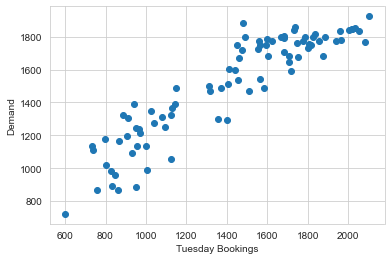

In [ ]:
X = df[['tues_bookings']]
y = df.demand

plt.ylabel('Demand')
plt.xlabel('Tuesday Bookings')
plt.scatter (X, y)

#### Trend & Seasonality Analysis

In this section we analyze the trend and seasonality by converting the demand data into a time series.

In [ ]:
df1 = pd.concat([df['days'], df['demand']], axis=1, keys=['days', 'demand'])
df1.set_index('days', inplace=True)
df1.head(5)

,demand
days,
1,1470.0
2,870.0
3,986.0
4,1247.0
5,1109.0


In [ ]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
demand,87.0,1503.724138,312.914755,722.0,1262.0,1600.0,1773.5,1924.0


<AxesSubplot:xlabel='days'>

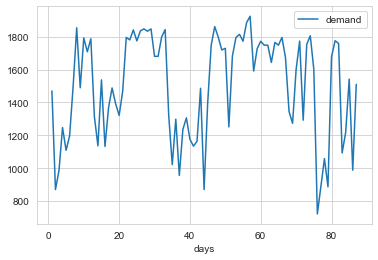

In [ ]:
df1.plot()

In [ ]:
time_series = df1['demand']
type(time_series)

pandas.core.series.Series

<AxesSubplot:xlabel='days'>

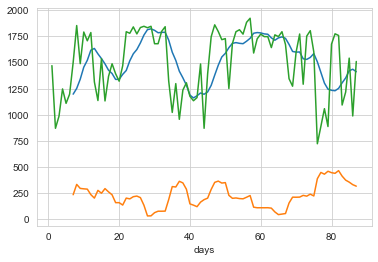

In [ ]:
time_series.rolling(7).mean().plot(label = '7 days rolling mean')
time_series.rolling(7).std().plot(label = '7 days rolling std')
time_series.plot()

<ipython-input-97-1486e6903d1e>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomp = seasonal_decompose(time_series, freq=7) # frequency set to 7 as there are 7 days in a week


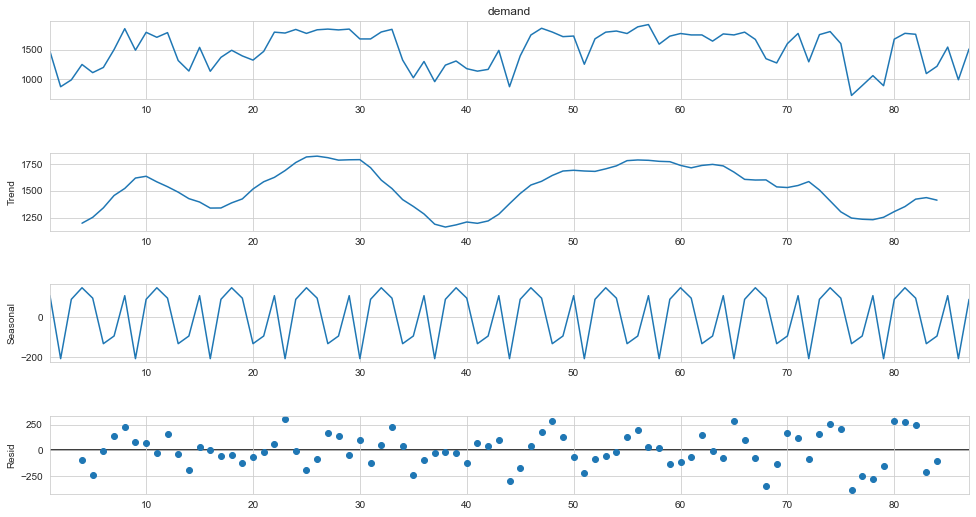

In [ ]:
decomp = seasonal_decompose(time_series, freq=7) # frequency set to 7 as there are 7 days in a week
fig = decomp.plot()
fig.set_size_inches(15,8)

### 5. Validation of forecasting methods

In this section, we evaluate the performance of 5 forecasting methods by fitting them on the demand data of weeks 1 to 11. We then predict the demand of weeks 12 and half of week 13 to calculate the `Mean Square Error` (MSE) with the real demand of said periods. We will choose the forecasting method with the minimum MSE.


In [ ]:
# Creating the training set and dropping the validation data

df_val = df.drop(df.index[77:])
df_val.tail(5)

,week,dow_indicator,days,demand,tues_bookings,pickup_ratio,dow_index
72,11,3,73,1753.0,1807.0,0.970,0.973
73,11,4,74,1805.0,1681.0,1.074,1.013
74,11,5,75,1601.0,1413.0,1.133,1.068
75,11,6,76,722.0,599.0,1.205,1.123
76,11,7,77,889.0,831.0,1.070,1.049


### Linear Regression

Linear regression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.


In [ ]:
X_val = df_val[['tues_bookings']]
y_val = df_val.demand

lin_reg_val = linear_model.LinearRegression()
lin_reg_val.fit(X_val, y_val)

print("The R^2 score for the linear regression is %f" % lin_reg_val.score(X_val, y_val)) 
# R^2 score for linear regression is 0.841

print ("The regression coefficient is %f" % lin_reg_val.coef_) 
print ("The regression intercept is %f" % lin_reg_val.intercept_)
# y = 0.67*x + 568.04

The R^2 score for the linear regression is 0.841096
The regression coefficient is 0.671358
The regression intercept is 568.036709


In [ ]:
pred_lin_reg_val = lin_reg_val.predict([[1123], [952], [1750], [1777],[1748],[932],[969],[1562],[1004],[1404]])
pred_lin_reg_val

array([1321.97182457, 1207.16959412, 1742.91333623, 1761.04000419,
       1741.57062008, 1193.74243266, 1218.58268135, 1616.69801854,
       1242.0802139 , 1510.62344303])

In [ ]:
expected = [1058,887, 1676,1775,1759,1093,1217,1542,988,1510]

mae_lin_reg_val = mean_absolute_error(expected, pred_lin_reg_val)
print('MAE for linear regression is %f' % mae_lin_reg_val)

MAE for linear regression is 111.417092


In [ ]:
mse_lin_reg_val = mean_squared_error(expected, pred_lin_reg_val)
print('MSE for linear regression is %f' % mse_lin_reg_val)
rmse_lin_reg_val = math.sqrt(mse_lin_reg_val)
print('RMSE for linear regression is %f' % rmse_lin_reg_val)

MSE for linear regression is 25745.423287
RMSE for linear regression is 160.453804


### Isotonic Regression

Isotonic regression or monotonic regression is the technique of fitting a free-form line to a sequence of observations.

In [ ]:
# converting X_val data to 1D array for Isotonic regression
X1_val = np.array(df_val['tues_bookings'])

iso_reg_val = IsotonicRegression()
iso_reg_val.fit(X1_val,y_val)

print ("The R^2 score for the isotonic regression is %f" % iso_reg_val.score(X1_val, y_val))
# R^2 score for isotonic regression is 0.933

The R^2 score for the isotonic regression is 0.932813


In [ ]:
pred_iso_reg_val = iso_reg_val.predict([1123,952,1750,1777,1748,932,969,1562,1004,1404])
pred_iso_reg_val

array([1321.0625    , 1245.875     , 1779.5       , 1779.5       ,
       1779.5       , 1245.875     , 1245.875     , 1700.875     ,
       1251.62980769, 1466.75      ])

In [ ]:
expected = [1058,887, 1676,1775,1759,1093,1217,1542,988,1510]

mae_iso_reg_val = mean_absolute_error(expected, pred_iso_reg_val)
print('MAE for isotonic regression is %f' % mae_iso_reg_val)

MAE for isotonic regression is 139.794231


In [ ]:
mse_iso_reg_val = mean_squared_error(expected, pred_iso_reg_val)
print('MSE for isotonic regression is %f' % mse_iso_reg_val)
rmse_iso_reg_val = math.sqrt(mse_iso_reg_val)
print('RMSE for isotonic regression is %f' % rmse_iso_reg_val)

MSE for isotonic regression is 32996.292941
RMSE for isotonic regression is 181.648818


### Linear SVR

Support Vector Regression (SVR) is quite different than other Regression models. It uses the Support Vector Machine (SVM, a classification algorithm) algorithm to predict a continuous variable. While other linear regression models try to minimize the error between the predicted and the actual value, Support Vector Regression tries to fit the best line within a predefined or threshold error value.

In [ ]:
svr_reg_val = LinearSVR(random_state=0, tol=1e-5, max_iter=1e6)
svr_reg_val.fit(X_val, y_val)

print ("The R^2 score for Linear SVR is %f" % svr_reg_val.score(X_val, y_val))
# R^2 score for linear svr is 0.566

print ("The SVR regression coefficient is %f" % svr_reg_val.coef_)
print ("The SVR regression intercept is %f" % svr_reg_val.intercept_)
# y = 1.054*x + 14.19

The R^2 score for Linear SVR is 0.566172
The SVR regression coefficient is 1.054674
The SVR regression intercept is 14.194957


In [ ]:
pred_svr_val = svr_reg_val.predict([[1123], [952], [1750], [1777],[1748],[932],[969],[1562],[1004],[1404]])
pred_svr_val

array([1198.59407062, 1018.24478433, 1859.87478702, 1888.35099012,
       1857.76543864,  997.15130055, 1036.17424554, 1661.59603952,
       1073.08784215, 1494.95751768])

In [ ]:
expected = [1058,887, 1676,1775,1759,1093,1217,1542,988,1510]

mae_svr_val = mean_absolute_error (expected, pred_svr_val)
print('MAE for linear SVR is %f' % mae_svr_val)

MAE for linear SVR is 116.423089


In [ ]:
mse_svr_val = mean_squared_error(expected, pred_svr_val)
print('MSE for SVR is %f' % mse_svr_val)
rmse_svr_val = math.sqrt(mse_svr_val)
print('RMSE for SVR is %f' % rmse_svr_val)

MSE for SVR is 15705.923873
RMSE for SVR is 125.323277


### ARIMA

In [ ]:
df1_val = pd.concat([df_val['days'], df_val['demand']], axis=1, keys=['days', 'demand'])
df1_val.set_index('days', inplace=True)
df1_val.head(5)

,demand
days,
1,1470.0
2,870.0
3,986.0
4,1247.0
5,1109.0


In [ ]:
time_series = df1_val['demand']
X2_val = df1_val.demand

# p, d, q 
# p periods taken for autoregressive model
# d  integrated order, difference .. default = 1
# q periods in moving average model

arima_val = arima.ARIMA(X2_val , order=(6,1,1))
arima_val_fit = arima_val.fit()

/Users/anthonyriachy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/anthonyriachy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was p

In [ ]:
pred_arima_val = arima_val_fit.forecast(steps = 10)[0]
pred_arima_val

array([1238.75755457,  845.70953364, 1060.3256149 , 1193.77084656,
       1459.42752034, 1004.63386531, 1137.00257025, 1289.66032376,
       1061.447701  , 1075.9879391 ])

In [ ]:
expected = [1058,887, 1676,1775,1759,1093,1217,1542,988,1510]

mae_arima_val = mean_absolute_error (expected, pred_arima_val)
print('MAE for ARIMA is %f' % mae_arima_val)

MAE for ARIMA is 264.668704


In [ ]:
mse_arima_val = mean_squared_error(expected, pred_arima_val)
print('MSE for ARIMA is %f' % mse_arima_val)
rmse_arima_val = math.sqrt(mse_arima_val)
print('RMSE for ARIMA is %f' % rmse_arima_val)

MSE for ARIMA is 111264.865251
RMSE for ARIMA is 333.563885


### Holt Winters


In [ ]:
holtwinters_val = holtwinters.ExponentialSmoothing(X2_val, seasonal_periods=7)
holtwinters_val = holtwinters.ExponentialSmoothing(X2_val)
holtwinters_val_fit = holtwinters_val.fit()

/Users/anthonyriachy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/anthonyriachy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/anthonyriachy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [ ]:
pred_holtwinters_val = np.array(holtwinters_val_fit.forecast(steps =10))
pred_holtwinters_val

/Users/anthonyriachy/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


array([963.45782045, 963.45782045, 963.45782045, 963.45782045,
       963.45782045, 963.45782045, 963.45782045, 963.45782045,
       963.45782045, 963.45782045])

In [ ]:
expected = [1058,887, 1676,1775,1759,1093,1217,1542,988,1510]

mae_holtwinters_val = mean_absolute_error (expected, pred_holtwinters_val)
print('MAE for Holt Winters is %f' % mae_holtwinters_val)

MAE for Holt Winters is 402.333744


In [ ]:
mse_holtwinters_val = mean_squared_error(expected, pred_holtwinters_val)
print('MSE for Holt Winters is %f' % mse_holtwinters_val)
rmse_holtwinters_val = math.sqrt(mse_holtwinters_val)
print('RMSE for Holt Winters is %f' % rmse_holtwinters_val)

MSE for Holt Winters is 252907.498748
RMSE for Holt Winters is 502.899094


### 6. Results assessment

In this section, we compare the `RMSE` of the 5 forecasting methods used in the previous section. The model with the lowest `RMSE` will be chosen to forecast the demand of week 13 until end of week 14.

In [ ]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Isotonic Regression', 'Linear SVR', 
              'ARIMA', 'Holt Winters'],
    'RMSE': [rmse_lin_reg_val, rmse_iso_reg_val, rmse_svr_val, 
              rmse_arima_val, rmse_holtwinters_val]})

models.sort_values(by='RMSE', ascending=True)

,Model,RMSE
2,Linear SVR,125.323277
0,Linear Regression,160.453804
1,Isotonic Regression,181.648818
3,ARIMA,333.563885
4,Holt Winters,502.899094


#### `Linear SVR` model has the lowest `RMSE` of **125.32**. 

#### Next, we will use `Linear SVR` model to forecast the demand of week 13 starting day 4 until end of week 14.

### Forecasting with Linear SVR

In [ ]:
svr_regr = LinearSVR(random_state=0, tol=1e-5, max_iter=1e6)
svr_regr.fit(X, y)

svr_regr.score(X, y)

0.628914183763787

In [ ]:
# Linear SVR regression has the form of y = a*x +b 
# "a" represents the regression's coefficient 
# "b" represents the regression's intercept

print (svr_regr.coef_ , svr_regr.intercept_)

# y = 1.04*x + 15.4

[1.03837966] [15.40064697]


In [ ]:
svr_regr.predict([[1657],[1643],[1124],[1074],[1839],[1862],[1886],[1696],[1002],[794],[1106]])

array([1735.99574228, 1721.45842705, 1182.53938392, 1130.62040096,
       1924.98084026, 1948.86357242, 1973.78468424, 1776.49254899,
       1055.8570655 ,  839.87409638, 1163.84855005])

### 7. Recommendation & action plan 

Based on the predictions of the `Linear SVR` model, it seems that the predict demand for Saturday is of **1925** rooms. That being said, we do not encourage manager Snow to take the additional **60** rooms as the prediction shows that they are overbooked by **48** rooms *(1925 - 1877 = 48)*.

##### Snow should reject the request in its entirety.

#### Risk & mitigation

* Risk 1: Forecast is not accurate - Mitigation: Feed more data into the model
* Risk 2: High number of no-shows -  Mitigation: Require a deposit to protect the hotel from lost revenue
* Risk 3: Last minute cancellations - Mitigation: Apply discounts to rooms if they are empty on short notice.